# Biometter-Classification
생물 분자간의 충돌 시뮬레이션 분석  
CNN 사용

In [9]:
# CopyRight kairos03 2017. All Right Reserved.

import tensorflow as tf
import time
from data import input_data
import numpy as np

## Hyper Parameter
하이퍼파라미터 설정

In [11]:
# hyper parameter
learning_rate = 1e-3
total_epoch = 50
batch_size = 30
dropout_keep_prob = 0.9

## Log path 
로그 저장 위치 지정

In [12]:
# name, log, model path setting
name = 'lr_{}_epoch_{}_batch_{}_{}'.format(learning_rate, total_epoch, batch_size, time.time())
log_root = './log/' + name + '/'
model_root = './model/' + name + '/'

## Basic Layer
기본 기능을 포함하는 베이직레이어 생성 추후 상속 받아 사용

In [14]:
class BasicLayer:
    def var_summary(self, name, var):
        with tf.name_scope(name):
            mean = tf.reduce_mean(var)
            stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
            tf.summary.scalar('stddev', stddev)
            tf.summary.scalar('mean', mean)
            tf.summary.histogram('histogram', var)

    def var_weight(self, shape, stddev=0.1):
        var = tf.truncated_normal(shape, stddev=stddev)
        self.var_summary('W', var)
        return tf.Variable(var)

    def var_bias(self, shape):
        var = tf.constant(0.1, shape=shape)
        self.var_summary('B', var)
        return tf.Variable(var)


## Convolution Layer
Conv2d 레이어 클래스

In [15]:
class Conv2dLayer(BasicLayer):
    def __init__(self, input, filter_size, strides, padding, activation=tf.nn.relu):
        self.input = input
        self.filter_size = filter_size
        self.strides = strides
        self.padding = padding
        self.activation = activation

    def make_layer(self):
        filter = self.var_weight(self.filter_size)
        conv = tf.nn.conv2d(self.input, filter, strides=self.strides, padding=self.padding)
        conv = self.activation(conv)
        tf.summary.histogram('act', conv)
        return conv

## Fully Connected Layer
모델의 마지막단에 사용할 FC Layer 클래스

In [16]:
class FullConnectedLayer(BasicLayer):
    def __init__(self, input, input_dim, output_dim, activation=tf.nn.relu):
        self.input = input
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.activation = activation

    def make_layer(self):
        weight = self.var_weight([self.input_dim, self.output_dim])
        bias = self.var_bias([self.output_dim])
        fc = tf.matmul(self.input, weight) + bias
        fc = self.activation(fc)
        tf.summary.histogram('act', fc)
        return fc

## CNN Model 정의
- input은 640x512x2의 파일로 흑백의 앞, 오른쪽 이미지 두장을 같이 넘김
- Convolution Layer 3개, MaxPool 2개, FullyConnected Layer 2개로 구성
- 마지막 FC에 drop out 적용
- 모든 Layer의 Activation 함수는 ReLU
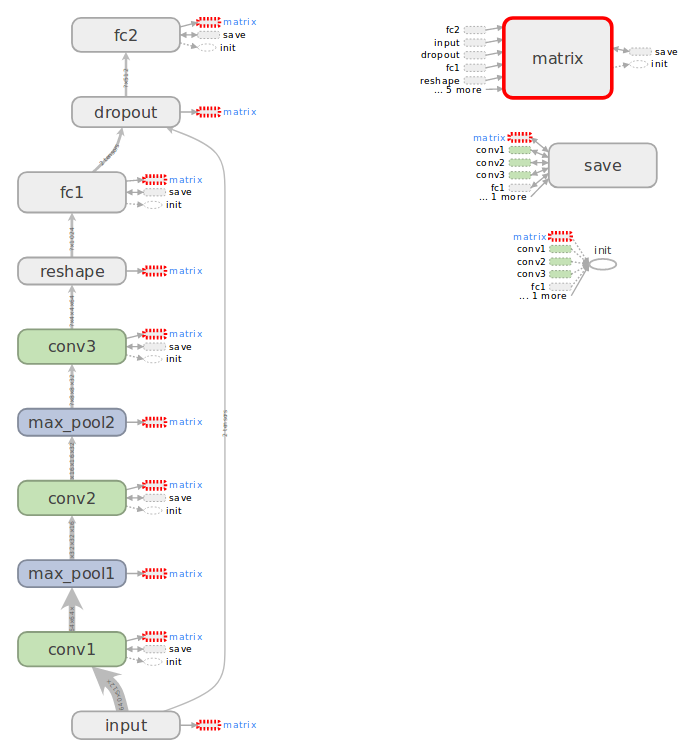

In [17]:
def train():
    """main train"""

    # input
    with tf.name_scope('input'):
        X = tf.placeholder(tf.float32, [None, 640, 512, 2], name='X')
        Y = tf.placeholder(tf.float32, [None, 2], name='Y')
        keep_prob = tf.placeholder(tf.float32)

    # input image summary
    # with tf.name_scope('input_image'):
    #     tf.summary.image('input', X, 10)

    # layers
    with tf.name_scope('conv1'):
        conv1 = Conv2dLayer(X, [10, 10, 2, 16], strides=[1, 10, 8, 1], padding='SAME').make_layer()

    with tf.name_scope('max_pool1'):
        pool1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('conv2'):
        conv2 = Conv2dLayer(pool1, [3, 3, 16, 32], strides=[1, 2, 2, 1], padding='SAME').make_layer()

    with tf.name_scope('max_pool2'):
        pool2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='SAME')

    with tf.name_scope('conv3'):
        conv3 = Conv2dLayer(pool2, [3, 3, 32, 64], strides=[1, 2, 2, 1], padding='SAME').make_layer()

    with tf.name_scope('reshape'):
        reshaped = tf.reshape(conv3, [-1, 4 * 4 * 64])

    with tf.name_scope('fc1'):
        fc1 = FullConnectedLayer(reshaped, 4 * 4 * 64, 512).make_layer()

    with tf.name_scope('dropout'):
        droped = tf.nn.dropout(fc1, keep_prob)

    with tf.name_scope('fc2'):
        model = FullConnectedLayer(droped, 512, 2, activation=tf.identity).make_layer()

    # matrix define
    with tf.name_scope('matrix'):
        xent = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=model, labels=Y), name='xent')
        optimizer = tf.train.AdamOptimizer(learning_rate).minimize(xent)
        accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(model, 1), tf.argmax(Y, 1)), tf.float32), name='accuracy')

        tf.summary.scalar('accuracy', accuracy)
        tf.summary.scalar('xent', xent)

    # Train Start
    print('Start')
    v_acc = 0

    # Crosss Validation Training
    for validation_epoch in range(5):
        print('\nValidation Set {}'.format(validation_epoch))
        # data load
        train_data, test_data = input_data.read_cross_validation_data_set(validation_epoch)

        # summary setting
        train_log = tf.summary.FileWriter(log_root+'train{}'.format(validation_epoch))
        test_log = tf.summary.FileWriter(log_root+'test{}'.format(validation_epoch))
        merged = tf.summary.merge_all()
        saver = tf.train.Saver()

        def next_batch(batch, is_train=True, one_hot=True):
            """ get next batch
                Args:
                    batch: current batch iteration, int
                    is_train: if False return Test data, default True
                    one_hot: if True return one hot encoded data, default True
                Returns:
                    xs: image data
                    ys: label data
            """
            # select data
            if is_train:
                xs = train_data['image'][:(batch + 1) * batch_size]
                ys = train_data['is_contacted'][:(batch + 1) * batch_size]

            else:
                xs = train_data['image'][:]
                ys = train_data['is_contacted'][:]

            # reform data
            ys = np.array(ys)

            # one hot encoding
            if one_hot:
                ys = np.array(ys).reshape(-1).astype(int)
                ys = np.eye(2)[ys]

            return xs, ys

        # train session
        with tf.Session() as sess:
            tf.global_variables_initializer().run()
            train_log.add_graph(sess.graph)

            total_batch = len(train_data['image']) // batch_size

            print('Train Start')
            for epoch in range(total_epoch):
                total_loss = 0
                summary = None

                # train data shuffle
                train_data, test_data = input_data.read_cross_validation_data_set(validation_epoch)

                for batch in range(total_batch):
                    xs, ys = next_batch(batch)

                    summary, loss, acc, _ = sess.run([merged, xent, accuracy, optimizer],
                                                feed_dict={
                                                    X: xs,
                                                    Y: ys,
                                                    keep_prob: dropout_keep_prob})
                    total_loss += loss

                train_log.add_summary(summary, epoch)
                avg_loss = total_loss / total_batch
                print('epoch: {:05}, loss: {:.5}, acc: {:.5}'.format(epoch, avg_loss, acc))

                if epoch == 0 or epoch % 5 == 4:
                    xs, ys = next_batch(None, False)

                    summary, acc = sess.run([merged, accuracy],
                                            feed_dict={
                                                X: xs,
                                                Y: ys,
                                                keep_prob: 1})

                    test_log.add_summary(summary, epoch)
                    print('accuracy: {:.4}'.format(acc))

            saver.save(sess, model_root+'acc_{:.4}.ckpt'.format(acc))
            print('Train Finish')

            # test
            # test data prepocess
            xs = np.concatenate((train_data['image'][:], test_data['image'][:]))
            ys = np.concatenate((train_data['is_contacted'][:], test_data['is_contacted'][:]))
            ys = np.array(ys)
            ys = np.array(ys).reshape(-1).astype(int)
            ys = np.eye(2)[ys]

            acc = sess.run([accuracy],
                           feed_dict={
                               X: xs,
                               Y: ys,
                               keep_prob: 1
                           })

            v_acc += acc[0]

            print('TEST ACCURACY: {:.5}'.format(acc[0]))

        train_log.close()
        test_log.close()

    print('Finish')
    print('Final AVG ACCURACY {:.5}'.format(v_acc/5))

In [ ]:
train()

Start

Validation Set 0
Train Start
